In [7]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import copy
import torch
import csv
from synthetic_env_julia_solver import synthetic_env
from naive_agents import DoNothing, FixedPhi
#from dynamic_phi_agent import DynamicPhiAgent
from actor_physicists_new import RL_phi_agent


In [2]:
beta = 0.1
kappa = 0.001
D = 0.1
nu = 0.99
start_sep = 0.75

In [3]:
def compare_agents(agent_list,identfiers, sep_size=0.02*np.pi,num_eps=100,time_horizon=25):
    label_index=0
    labels=[]
    colors = ["C2","C1"]
    agent_number=0
    
    for agent in agent_list:
        env = synthetic_env(start_sep,beta,kappa,D,nu)
        env.limit = time_horizon
        cum_rew=np.zeros(int(env.limit/env.deltaT))
        for i in range(0,num_eps):
            time_step=0
            episode_rew=0
            while not env.isOver():
                action=agent.sample_action(env.getState())
                reward = env.step(action)
                episode_rew += reward
                cum_rew[time_step] += episode_rew
                time_step += 1
            env.reset()
        if agent_number%2 == 0:
            plt.plot(np.arange(len(cum_rew))/(1/env.deltaT),cum_rew/num_eps,f"{colors[agent_number//2]}")
        else:
            plt.plot(np.arange(len(cum_rew))/(1/env.deltaT),cum_rew/num_eps, f"{colors[agent_number//2]}--")
        labels.append(identfiers[label_index])
        label_index+=1
        agent_number +=1
    
        
    plt.legend(labels)
    plt.title(f"Avg Cumalative Reward")
    plt.xlabel("episode time")
    plt.ylabel("reward")
    


def compare_agents_distances(agent_list,identfiers, sep_size=0.02*np.pi, num_eps=100):
    label_index=0
    labels=[]
    
    for agent in agent_list:
        env = synthetic_env()
        cum_dist=np.zeros(int(env.limit/env.deltaT)+1)
        for i in range(0,num_eps):
            time_step=0
            while not env.isOver():
                action=agent.sample_action(env.getState())
                env.step(action)
                cum_dist[time_step] += env.dist()
                time_step += 1
            env.reset()
        plt.plot(np.arange(len(cum_dist))/(1/env.deltaT),cum_dist/num_eps)
        labels.append(identfiers[label_index])
        label_index+=1
    plt.legend(labels)

    
    
def plot_agent_trajectory(agent, sep_size=0.02*np.pi, seed=1):
    env = synthetic_env()
#    print(env.passive)
#    print(env.active)
    active = np.array([]).reshape(0, 3)
    passive = np.array([]).reshape(0, 3)
    
    while not env.isOver():
        active = np.vstack((active, env.active))
        passive = np.vstack((passive, env.passive))
        state = env.getState()
        action = agent.sample_action(state)
        env.step(action)
    
    fig = go.Figure(data=go.Scatter3d(
        x=passive[:,0],
        y=passive[:,1],
        z=passive[:,2],
        mode='lines',
        name = "passive"
      )
    )
    
    fig.add_trace(go.Scatter3d(
        x=active[:,0],
        y=active[:,1],
        z=active[:,2],
        mode='lines',
        name = "active"
      )
    )
#    print(env.passive)
#    print(env.active)
    fig.show()
    
def plot_phis(agent, sep_size=0.02*np.pi, seed=1):
    env = synthetic_env()
    phis=[]
    while not env.isOver():
        state = env.getState()
        action = agent.sample_action(state)
        phi = (action @ state) / (state @ state)
        env.step(action)
        phis.append(phi)
        
        
    window_size = 100
    avg_phis = []

    # Calculate sliding window averages
    for i in range(len(phis) - window_size + 1):
        window = phis[i : i + window_size]
        window_avg = np.mean(window)
        avg_phis.append(window_avg)
    
    
    plt.plot(avg_phis)

In [4]:
def compare_agents_avg_return(agent_list,identfiers, sep_size=0.2*np.pi,num_eps=100,time_horizon=10.):
    final_summed_rewards = []
    agent_episode_rewards = {}
    agent_id = 0
    
    for agent in agent_list:
        agent_episode_rewards[identfiers[agent_id]] = []
        env = synthetic_env(sep_size,beta,kappa,D,nu)
        env.limit = time_horizon
        summed_rew = 0
        for i in range(0,num_eps):
            episode_rew=0
            while not env.isOver():
                action=agent.sample_action(env.getState())
                reward = env.step(action)
                episode_rew += reward
            agent_episode_rewards[identfiers[agent_id]].append(episode_rew)
            summed_rew += episode_rew
            env.reset()
        final_summed_rewards.append(summed_rew)
        agent_id += 1
        
        
        
    print(f"Average rewards over {num_eps} episodes:\n")
    for i in range(len(identfiers)):
        name = identfiers[i]
        avg_rew = final_summed_rewards[i]/num_eps
        print(f"{name:<15} {avg_rew:.5f}")
    
    
    return agent_episode_rewards

In [20]:
phis = [0.3,0.574,0.9,1.2]
agents = []
identifiers = []
for phi in phis:
    fixed_phi = FixedPhi(phi)
    name = f"fixed_{phi}"
    agents.append(fixed_phi)
    identifiers.append(name)
    
    trained = RL_phi_agent(action_scale=5.)
    trained.load_policy(f"saved_models/julia_num_env_{phi}_10.0.pt")
    trained_name = f"RL_trained_{phi}"
    agents.append(trained)
    identifiers.append(trained_name)
    

sampled_rewards = compare_agents_avg_return(agents,identifiers,num_eps=1000)

Average rewards over 1000 episodes:

fixed_0.3       -0.20560
RL_trained_0.3  -0.18041
fixed_0.574     -0.17438
RL_trained_0.574 -0.17883
fixed_0.9       -0.21621
RL_trained_0.9  -0.19139
fixed_1.2       -0.26294
RL_trained_1.2  -0.17354


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  1.,  0.,  0.,  1.,  0.,  3.,  0.,  0.,  0.,  3.,
         1.,  0.,  4.,  3.,  1.,  4.,  7.,  7., 14., 13., 11., 19., 16.,
        22., 40., 35., 41., 43., 44., 60., 42., 34., 20.,  8.]),
 array([-0.66410965, -0.65253862, -0.64096758, -0.62939654, -0.6178255 ,
        -0.60625447, -0.59468343, -0.58311239, -0.57154135, -0.55997032,
        -0.54839928, -0.53682824, -0.5252572 , -0.51368617, -0.50211513,
        -0.49054409, -0.47897305, -0.46740202, -0.45583098, -0.44425994,
        -0.4326889 , -0.42111786, -0.40954683, -0.39797579, -0.38640475,
        -0.37483371, -0.36326268, -0.35169164, -0.3401206 , -0.32854956,
        -0.31697853, -0.30540749, -0.29383645, -0.28226541, -0.27069438,
        -0.25912334, -0.2475523 , -0.23598126, -0.22441023, -0.21283919,
        -0.20126815, -0.18969711, -0.17812608, -0.16655504, -0.154984  ,
        -0.14341296, -0.13184192, -0.12027089, -0.10869985,

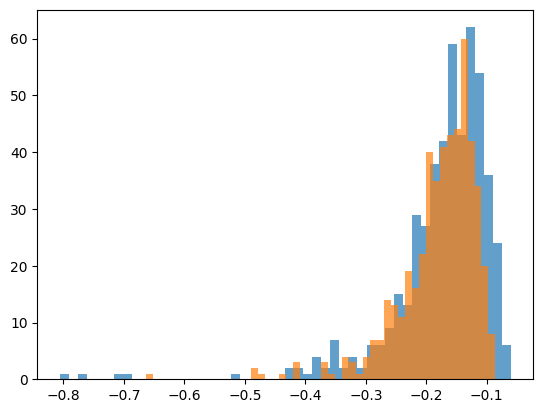

In [19]:
plt.hist(sampled_rewards["RL_trained_1.2"],bins=50,alpha=0.7)
plt.hist(sampled_rewards["fixed_0.574"],bins=50,alpha=0.7)

In [22]:
phis = [0.1,0.199,0.201]
agents = []
identifiers = []
for phi in phis:
    fixed_phi = FixedPhi(phi)
    name = f"fixed_{phi}"
    agents.append(fixed_phi)
    identifiers.append(name)
    
    trained = RL_phi_agent(action_scale=5.)
    trained.load_policy(f"saved_models/julia_num_env_{phi}_10.0.pt")
    trained_name = f"RL_trained_{phi}"
    agents.append(trained)
    identifiers.append(trained_name)
    

sampled_rewards_bad_baseline = compare_agents_avg_return(agents,identifiers,num_eps=100)

Average rewards over 100 episodes:

fixed_0.1       -0.62518
RL_trained_0.1  -17300057286775631872.00000
fixed_0.199     -0.26873
RL_trained_0.199 -0.25373
fixed_0.201     -0.23468
RL_trained_0.201 -0.80050


In [12]:
with open(f'csv/synth_results_params{beta},{kappa},{D},{nu}.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=list(sampled_rewards.keys()))
    writer.writeheader()
    writer.writerow(sampled_rewards)

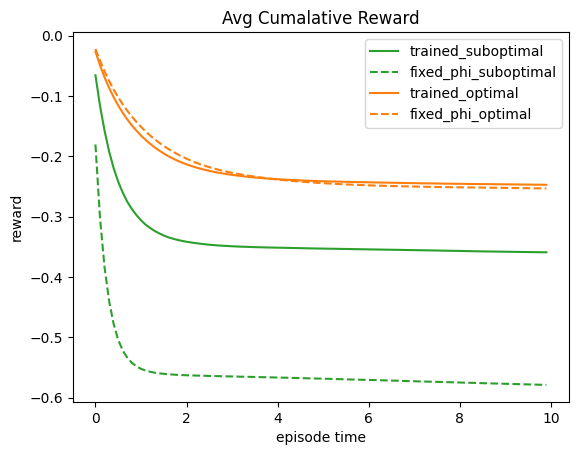

In [20]:
#do_nothing = DoNothing()
fixed_phi = FixedPhi(2.0) # need to retune
optimal = FixedPhi(0.574)
trained = RL_phi_agent(action_scale=5.)
trained_optimal = RL_phi_agent(action_scale=5.)
trained_optimal.load_policy("saved_models/julia_num_env_0.574_10.0.pt")
trained.load_policy("saved_models/julia_num_env_2.pt")
compare_agents([ trained , fixed_phi,trained_optimal,optimal],
              ["trained_suboptimal", "fixed_phi_suboptimal","trained_optimal","fixed_phi_optimal"],time_horizon=10.0,#,"trained_rescaled_baseline"],#"phi=2.7"],
               #1,
              num_eps=100)

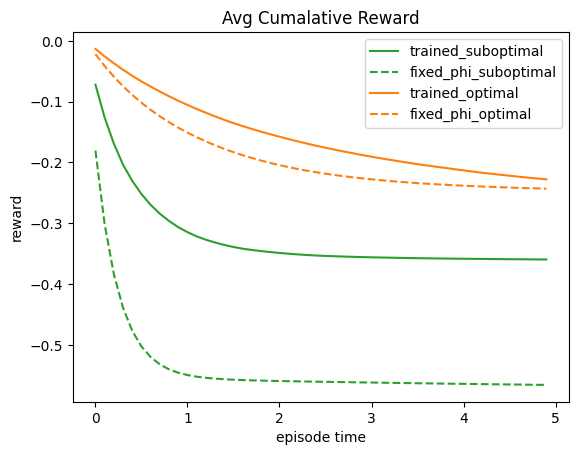

In [22]:
#do_nothing = DoNothing()
fixed_phi = FixedPhi(2.0) # need to retune
optimal = FixedPhi(0.574)
trained = RL_phi_agent(action_scale=5.)
trained_optimal = RL_phi_agent(action_scale=5.)
trained_optimal.load_policy("saved_models/julia_num_env_0.574_5.0.pt")
trained.load_policy("saved_models/julia_num_env_2.pt")
compare_agents([ trained , fixed_phi,trained_optimal,optimal],
              ["trained_suboptimal", "fixed_phi_suboptimal","trained_optimal","fixed_phi_optimal"],time_horizon=5.0,#,"trained_rescaled_baseline"],#"phi=2.7"],
               #1,
              num_eps=100)

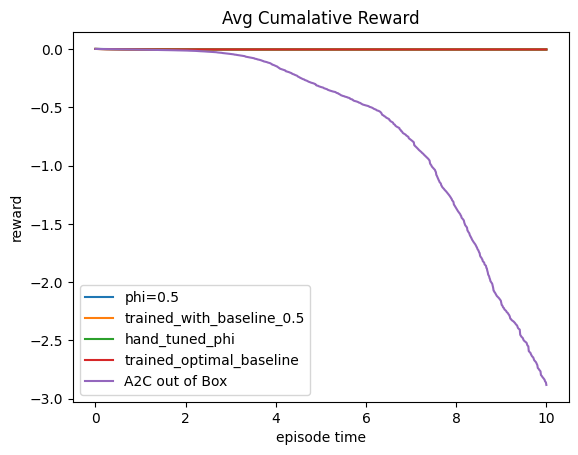

In [4]:
#do_nothing = DoNothing()
moderate_phi = FixedPhi(0.5)phis = [0.3,0.6,0.9,1.2]
agents = []
identifiers = []
for phi in phis:
    fixed_phi = FixedPhi(phi)
    name = f"fixed_{phi}"
    agents.append(fixed_phi)
    identifiers.append(name)
    
    trained = RL_phi_agent(action_scale=5.)
    trained.load_policy(f"saved_models/julia_num_env_{phi}_10.0.pt")
    trained_name = f"RL_trained_{phi}"
    agents.append(trained)
    identifiers.append(trained_name)
    

sampled_rewards = compare_agents_avg_return(agents,identifiers,num_eps=500)
hand_tuned_phi = FixedPhi(1.1)
fixedhigh = FixedPhi(2.7)
trained = DynamicPhiAgent(action_scale=5.)
trained_optimal = DynamicPhiAgent(action_scale=5.)
trained.load_policy("saved_models/phi_only_0.5.pt")
trained_optimal.load_policy("saved_models/phi_only_1.1.pt")
compare_agents([moderate_phi, trained ,hand_tuned_phi,trained_optimal],#,fixedhigh],
              ["phi=0.5","trained_with_baseline_0.5","hand_tuned_phi","trained_optimal_baseline"],#"phi=2.7"],
               #1,
              num_eps=1)

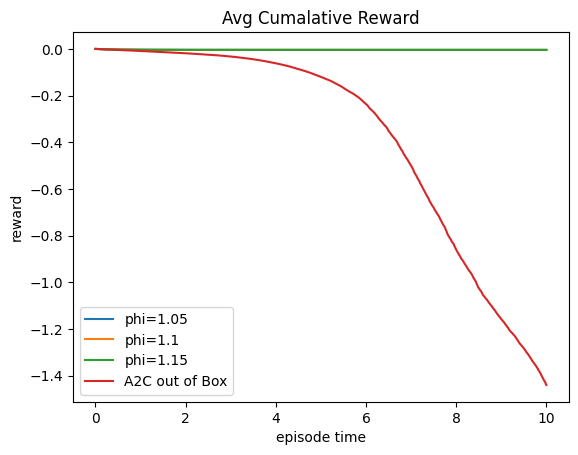

In [5]:
start=105
end=120
agents = [FixedPhi(i/100) for i in range(start,end,5)]
compare_agents(agents, [f"phi={i/100}" for i in range(start,end,5)],num_eps=20)

In [6]:
for i in range(100,120,5):
    print(i)

100
105
110
115


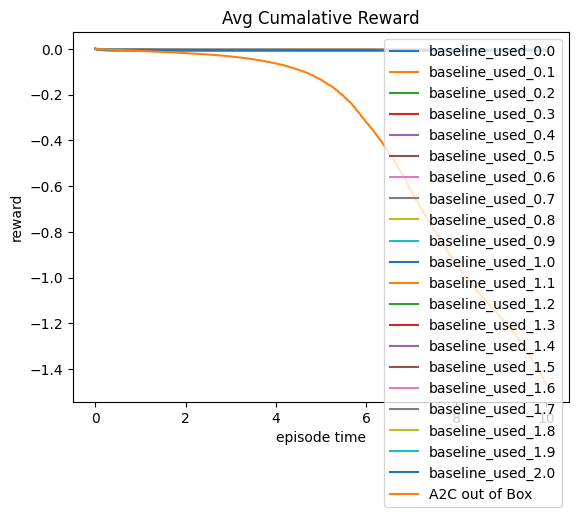

In [7]:
agents = [DynamicPhiAgent(action_scale=5.) for i in range(0,21)]
for i in range(0,21):
    agents[i].load_policy(f"saved_models/phi_only_{i/10}.pt")
compare_agents(agents, [f"baseline_used_{i/10}" for i in range(0,21)],num_eps=20)

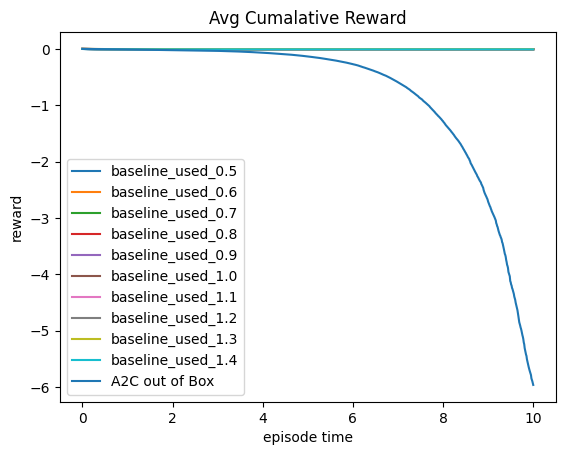

In [8]:
start=5
end=15
agents = [DynamicPhiAgent(action_scale=5.) for i in range(start,end)]
for i in range(end-start):
    agents[i].load_policy(f"saved_models/phi_only_{i/10}.pt")
compare_agents(agents, [f"baseline_used_{i/10}" for i in range(start,end)],num_eps=50)

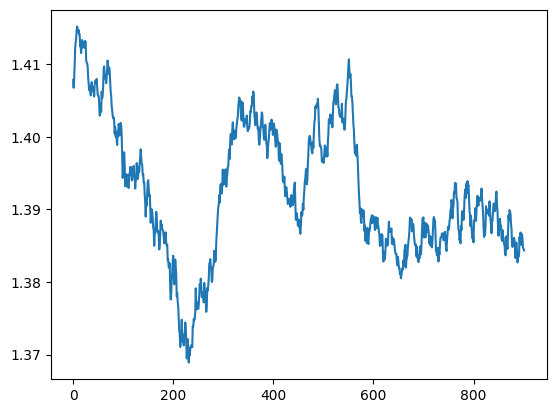

In [9]:
plot_phis(trained,seed=1)

In [10]:
plot_phis(mean_plus_var,seed=1)

NameError: name 'mean_plus_var' is not defined

In [ ]:
compare_agents_distances([moderate_phi,hand_tuned_phi,trained],
              ["moderate_phi","hand_tuned_phi","trained_doofus"],
               1,
              num_eps=20)

In [ ]:
for i in range(0,10):
    print(i/10)

In [ ]:
plot_agent_trajectory(moderate_phi,seed=2)

In [ ]:
plot_agent_trajectory(untrained,seed=10)

In [ ]:
compare_agents_distances([untrained,do_nothing,moderate_phi],
              ["untrained","do_nothing","moderate_phi"],
              num_eps=20)

In [ ]:
#TODOs
"""
General todos. 
Create an RL only actor critic agent
Create an RL assisted actor critic agent (same class just an optional base action function?)
Create a dynamic phi tuning actor critic agent
    - application to guarentee a  lower bound on performance?
    - Future research PID dynamic coeffcients?
Then create both learns phi dynamically plus learns the correction`
    

"""

In [ ]:
import torch
torch.distributions.Normal

In [ ]:
phis = [0.3,0.6,0.9,1.2]
agents = []
identifiers = []
for phi in phis:
    fixed_phi = FixedPhi(phi)
    name = f"fixed_{phi}"
    agents.append(fixed_phi)
    identifiers.append(name)
    
    trained = RL_phi_agent(action_scale=5.)
    trained.load_policy(f"saved_models/julia_num_env_{phi}_10.0.pt")
    trained_name = f"RL_trained_{phi}"
    agents.append(trained)
    identifiers.append(trained_name)
    

sampled_rewards = compare_agents_avg_return(agents,identifiers,num_eps=500)a=torch.distributions.Normal(0,1.)

In [ ]:
a.log_prob(torch.tensor([2]))

In [ ]:
do_nothing = DoNothing()
weak = FixedPhi(0.1)
super_weak = FixedPhi(0.01)
compare_agents([do_nothing,weak,super_weak],
              ["do_nothing","weak","super_weak"],
              num_eps=20)

In [ ]:
means=torch.tensor([1.0,0.0]).view(-1,1)
stds=torch.tensor([1.0,3.0]).view(-1,1)

m = torch.distributions.Normal(means[:,0], stds[:,0])
samples = m.sample().view(-1,1)  # normally distributed with loc=0 and scale=1
print(samples.size())
m.log_prob(samples)

In [ ]:
means[:,0].size()

In [ ]:
env = ABCflow(a=0.,b=0.,c=0.)
env.limit=2.
#env.reset()
while not env.isOver():
    env.step(-env.getState())
print(np.linalg.norm(env.getState()))

In [ ]:
np.exp(np.array([[1.],phis = [0.3,0.6,0.9,1.2]
agents = []
identifiers = []
for phi in phis:
    fixed_phi = FixedPhi(phi)
    name = f"fixed_{phi}"
    agents.append(fixed_phi)
    identifiers.append(name)
    
    trained = RL_phi_agent(action_scale=5.)
    trained.load_policy(f"saved_models/julia_num_env_{phi}_10.0.pt")
    trained_name = f"RL_trained_{phi}"
    agents.append(trained)
    identifiers.append(trained_name)
    

sampled_rewards = compare_agents_avg_return(agents,identifiers,num_eps=500)
                [2.]]))

In [ ]:
x = np.empty((0,3),float)
for i in range(10):
    x = np.vstack((x,np.random.rand(3)))
x

In [ ]:
x.shape

In [11]:
max([1,2,3])

3